In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

### image preparation functions

In [2]:
def to_binary(img):
    binary = np.zeros(img.shape[:2], dtype=np.int8)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i, j].all() > 0:
                binary[i, j] = 0
            else:
                binary[i, j] = 255


def to_bw(img):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i, j].all() > 0:
                img[i, j] = [0, 0, 0]
            else:
                img[i, j] = [255, 255, 255]


                
def digits_to_image(matrix, zero, one):
    lines = []
    for i in range(matrix.shape[0]):
        items = []
        for j in range(matrix.shape[1]):
            if matrix[i, j] == 0:
                items.append(zero)
            elif matrix[i, j] == 1:
                items.append(one)
            else:
                raise Exception(f"undefined digit on ({i},{j})")
        lines.append(np.concatenate(items, axis=1))
    full_img = np.concatenate(lines, axis=0)
    return full_img


def image_to_digits(image, zero, one):
    x_step = zero.shape[0]
    y_step = zero.shape[1]
    x_len = image.shape[0] // zero.shape[0]
    y_len = image.shape[1] // zero.shape[1]
    print(f"vertical steps: {x_len}, horisontal steps {y_len}")
    image_names = np.zeros((x_len, y_len), dtype=np.int8)
    penalties = np.zeros((x_len, y_len, 2), dtype=np.int16)
    for x in range(x_len):
        for y in range(y_len):
            penalty0 = 0
            penalty1 = 0
            for i in range(zero.shape[0]):
                for j in range(zero.shape[1]):
                    if image[x * x_step + i, y * y_step + j].any() != zero[i, j].any():
                        penalty0 += 1
                    if image[x * x_step + i, y * y_step + j].any() != one[i, j].any():
                        penalty1 += 1
            image_names[x, y] = (1 if penalty1 < penalty0 else 0)
            penalties[x, y] = [penalty0, penalty1]
    return image_names, penalties

### CYK problem solving functions

In [3]:
def add_noise(array, prob=0.2):
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            array[i, j]=(array[i, j] + np.random.choice([255, 0], size=1, p=[prob, 1-prob])) % 510


            
def find_all_penalties(penalties, imgs_x1, grammar_len,  require_rest, leave_rest):
    #1 find penalties for each column case
    full_img_penalties = np.zeros((imgs_x1, grammar_len), dtype=float)
    for i in range(full_img_penalties.shape[0]):
        for j in range(full_img_penalties.shape[1]):    
            lower_k = j % 2
            middle_k = (j // 2) % 2
            higher_k = (j // 4) % 2
            full_img_penalties[i, j] = (
                penalties[2, i, lower_k]  +
                penalties[1, i, middle_k] +
                penalties[0, i, higher_k]
            )
    #2 find available for the last column
    for j, val in enumerate(require_rest):
        if val==1:
            full_img_penalties[-1, j] = np.inf
    #3 find available for the last column
    for j, val in enumerate(leave_rest):
        if val==1:
            full_img_penalties[0, j] = np.inf
            
    return full_img_penalties



def find_markup(penalties_matrix, require_rest, leave_rest, verbose=2):
    idx_leave_rest = np.where(leave_rest == 1)[0]
    idx_not_leave_rest = np.where(leave_rest == 0)[0]
    min_penalty_idx = []
    #find min penalties for each case per binary column
    for i in range(penalties_matrix.shape[0]-2, -1, -1):
        idx_prev_leave_rest = idx_leave_rest[penalties_matrix[i+1, idx_leave_rest].argmin()]
        idx_prev_not_leave_rest = idx_not_leave_rest[penalties_matrix[i+1, idx_not_leave_rest].argmin()]
        for this_col in range(penalties_matrix.shape[1]):
            if require_rest[this_col] == 1:
                penalties_matrix[i, this_col] = (penalties_matrix[i, this_col] + 
                                                 penalties_matrix[i+1, idx_prev_leave_rest]
                                                )
            if require_rest[this_col] == 0:
                penalties_matrix[i, this_col] = (penalties_matrix[i, this_col] + 
                                                 penalties_matrix[i+1, idx_prev_not_leave_rest]
                                                )
        min_penalty_idx.insert(0,[idx_prev_leave_rest, idx_prev_not_leave_rest]) 
    if verbose ==2:
        print(f"\npenalties_matrix\n {penalties_matrix}")
        
    #combine final markup   
    result_list = []
    result_list.append(np.argmin(penalties_matrix[0, :]))
    if penalties_matrix[0, result_list[0]] != np.inf:
        for i in range(penalties_matrix.shape[0]-1):
            if require_rest[result_list[i]] == 1: 
                result_list.append(min_penalty_idx[i][0])
            else:
                result_list.append(min_penalty_idx[i][1])
    else:
        raise Exception("incorrect input example!")
    if verbose >=1:
        print(f"\nresult_list\n {result_list}")
        
    #criate binary matrix according to markup
    result_matrix = np.zeros((3, len(result_list)))
    for i in range(result_matrix.shape[1]):
        result_matrix[2, i] =  result_list[i] % 2
        result_matrix[1, i] = (result_list[i] // 2) % 2
        result_matrix[0, i] = (result_list[i] // 4) % 2
    return result_matrix

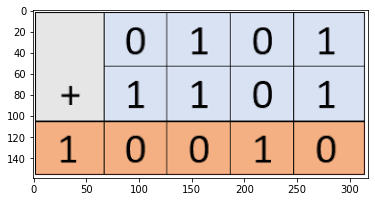

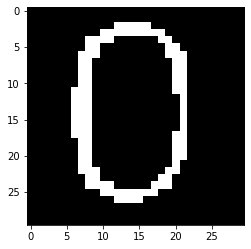

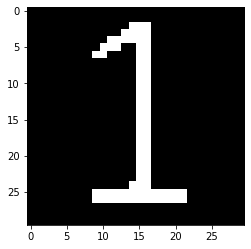

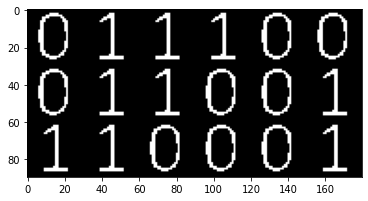

In [4]:
image = Image.open('./images/lab4.png').convert('RGB')
img_tenzor = np.asarray(image)
plt.imshow(img_tenzor)
plt.show()
to_bw(img_tenzor)
zero = img_tenzor[15:45, 83:113]
one = img_tenzor[15:45, 143:173]

plt.imshow(zero)
plt.show()
plt.imshow(one)
plt.show()


example = np.array([[0,1,1,1,0,0],
                    [0,1,1,0,0,1],
                    [1,1,0,0,0,1]])

full_img = digits_to_image(example, zero, one)
plt.imshow(full_img)
plt.show()

In [5]:
# Image.fromarray(one).save("./images/one.png")
# Image.fromarray(zero).save("./images/zero.png")
# Image.fromarray(full).save("./images/full.png")

 img shape (90, 180, 3)


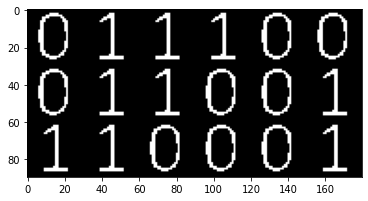

In [13]:
image = Image.open('./images/full.png')
zero = Image.open('./images/zero.png')
one = Image.open('./images/one.png')

img_tenzor = np.asarray(image)
zero = np.asarray(zero)
one = np.asarray(one)

shape = img_tenzor.shape
print(f' img shape {shape}')

plt.imshow(img_tenzor)
plt.show()

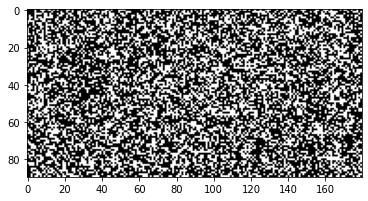

In [14]:
add_noise(img_tenzor, prob=0.4)
plt.imshow(img_tenzor)
plt.show()

In [15]:
labels, penalties = image_to_digits(img_tenzor, zero, one)
labels

vertical steps: 3, horisontal steps 6


array([[0, 1, 1, 1, 0, 0],
       [0, 1, 1, 0, 0, 1],
       [1, 1, 0, 0, 0, 1]], dtype=int8)

In [16]:
#Grammar

# 0 1 2 3 4 5 6 7

# 0 0 0 0 1 1 1 1   0
# 0 0 1 1 0 0 1 1   1
# 0 1 0 1 0 1 0 1   2

# E E E'E E'E E'E'

require_rest = arr = np.array([0, 1, 1, 0, 1, 0, 0, 1])
leave_rest = arr = np.array([0, 0, 1, 0, 1, 0, 1, 1])

In [17]:
penalties_matrix = find_all_penalties(penalties, imgs_x1=labels.shape[1], grammar_len=len(require_rest))
penalties_matrix

array([[1089., 1063.,   inf, 1097.,   inf, 1099.,   inf,   inf],
       [1145., 1127., 1111., 1093., 1095., 1077., 1061., 1043.],
       [1194., 1228., 1152., 1186., 1174., 1208., 1132., 1166.],
       [1158., 1196., 1168., 1206., 1142., 1180., 1152., 1190.],
       [1061., 1093., 1107., 1139., 1113., 1145., 1159., 1191.],
       [1126.,   inf,   inf, 1060.,   inf, 1132., 1122.,   inf]])

In [18]:
markup = find_markup(penalties_matrix, require_rest, leave_rest)
markup


penalties_matrix
 [[6627. 6517.   inf 6635.   inf 6637.   inf   inf]
 [5610. 5538. 5522. 5558. 5506. 5542. 5526. 5454.]
 [4473. 4501. 4425. 4465. 4447. 4487. 4411. 4439.]
 [3279. 3415. 3387. 3327. 3361. 3301. 3273. 3409.]
 [2121. 2215. 2229. 2199. 2235. 2205. 2219. 2313.]
 [1126.   inf   inf 1060.   inf 1132. 1122.   inf]]

result_list
 [1, 7, 6, 0, 0, 3]


array([[0., 1., 1., 0., 0., 0.],
       [0., 1., 1., 0., 0., 1.],
       [1., 1., 0., 0., 0., 1.]])

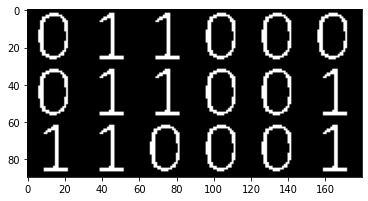

In [19]:
final_img = digits_to_image(markup, zero, one)
plt.imshow(final_img)
plt.show()